# Analisis Survival Breast Cancer MSK 2025

Notebook ini melakukan analisis survival pada data breast cancer dari MSK 2025, termasuk preprocessing data, pemodelan Cox Proportional Hazards, dan analisis Kaplan-Meier.

# 1. Library

In [91]:
# Import semua library yang digunakan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import logrank_test

# 2. Data Preparation

## 2.1 Import Data

In [92]:
# Import file .tsv
df = pd.read_csv('breast_msk_2025_clinical_data.tsv', sep='\t')

# Tampilkan nama kolom
print("Nama kolom:")
print(df.columns.tolist())

Nama kolom:
['Study ID', 'Patient ID', 'Sample ID', 'Cancer Type', 'Cancer Type Detailed', 'Ethnicity', 'Fraction Genome Altered', 'Sex', 'Gene Panel', 'Metastatic Site', 'MSI Comment', 'MSI Score', 'MSI Type', 'Mutation Count', 'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status', 'Primary Tumor Site', 'Race', 'Sample Class', 'Number of Samples Per Patient', 'Sample coverage', 'Sample Type', 'Somatic Status', 'Tumor Purity']


## 2.2 Data Cleaning and Preprocessing

In [93]:
# Data Preprocessing

# Cek nilai unik di kolom 'Sex'
print("Nilai unik di kolom 'Sex' sebelum cleaning:")
print(df['Sex'].unique())

# Standardize nilai di kolom 'Sex' ke 'Male' dan 'Female'
df['Sex'] = df['Sex'].str.capitalize()  # Capitalize untuk membuat Female dan Male

# Pastikan hanya Male dan Female, drop atau handle lainnya jika ada
df = df[df['Sex'].isin(['Male', 'Female'])]

print("Nilai unik di kolom 'Sex' setelah cleaning:")
print(df['Sex'].unique())

# Cek nilai unik di kolom 'Overall Survival Status' sebelum mapping
print("Nilai unik di kolom 'Overall Survival Status' sebelum mapping:")
print(df['Overall Survival Status'].unique())

# Mengubah nilai di kolom 'Overall Survival Status' (pindah ke sini)
df['Overall Survival Status'] = df['Overall Survival Status'].map({'1:DECEASED': 1, '0:LIVING': 0})

# Standardize nilai di kolom 'Primary Tumor Site' ke kapitalisasi konsisten
df['Primary Tumor Site'] = df['Primary Tumor Site'].str.capitalize()

# Tampilkan nilai unik setelah mapping untuk verifikasi
print("Nilai unik di kolom 'Overall Survival Status' setelah mapping:")
print(df['Overall Survival Status'].unique())

# Drop NaN di kolom yang diperlukan untuk analisis Cox dan KM
columns_needed = [
    'Overall Survival (Months)',
    'Overall Survival Status',
    'Sex',
    'Primary Tumor Site',
    'MSI Type',
    'Mutation Count',
    'Fraction Genome Altered'
]
df = df.dropna(subset=columns_needed)

print(f"Jumlah sampel setelah preprocessing: {len(df)}")

Nilai unik di kolom 'Sex' sebelum cleaning:
['FEMALE' 'Female' 'Male' 'Unknown' 'MALE']
Nilai unik di kolom 'Sex' setelah cleaning:
['Female' 'Male']
Nilai unik di kolom 'Overall Survival Status' sebelum mapping:
['1:DECEASED' '0:LIVING']
Nilai unik di kolom 'Overall Survival Status' setelah mapping:
[1 0]
Jumlah sampel setelah preprocessing: 3656


In [94]:
# Cek nilai unik Primary Tumor Site
print("Nilai unik di kolom 'Primary Tumor Site':")
print(df['Primary Tumor Site'].unique())
print(f"\nJumlah kategori: {df['Primary Tumor Site'].nunique()}")
print("\nDistribusi frekuensi:")
print(df['Primary Tumor Site'].value_counts())

Nilai unik di kolom 'Primary Tumor Site':
['Breast' 'Cancer of unknown primary']

Jumlah kategori: 2

Distribusi frekuensi:
Primary Tumor Site
Breast                       3655
Cancer of unknown primary       1
Name: count, dtype: int64


# 3. Kaplan-Meier Survival Analysis

### 3.1 Survival Curve by Sex

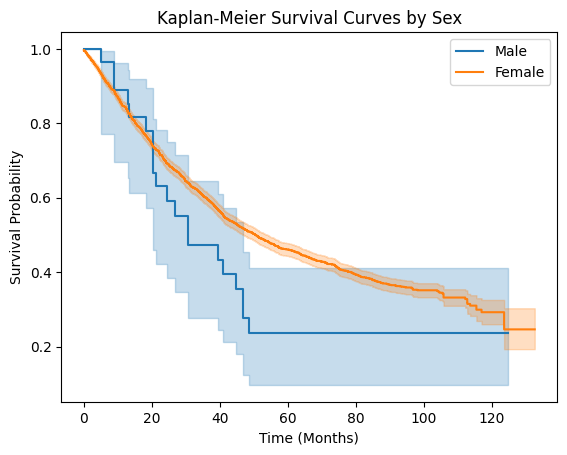

Jumlah Male: 30
Jumlah Female: 3626


In [95]:
# Buat Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Pisahkan data berdasarkan jenis kelamin
male = df[df['Sex'] == 'Male']
female = df[df['Sex'] == 'Female']

# Fit model untuk Male
kmf.fit(male['Overall Survival (Months)'], male['Overall Survival Status'], label='Male')
ax = kmf.plot()

# Fit model untuk Female
kmf.fit(female['Overall Survival (Months)'], female['Overall Survival Status'], label='Female')
kmf.plot(ax=ax)

# Tambahkan label dan judul
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curves by Sex')
plt.legend()
plt.show()

# Print jumlah sampel per kelompok
print(f"Jumlah Male: {len(male)}")
print(f"Jumlah Female: {len(female)}")

# Log-rank test untuk membandingkan survival curves antara Male dan Female
from lifelines.statistics import logrank_test


#### 3.1.1 Log Rank Test

In [96]:
results = logrank_test(
    male['Overall Survival (Months)'], 
    female['Overall Survival (Months)'],
    male['Overall Survival Status'], 
    female['Overall Survival Status']
)

print("\n" + "=" * 60)
print("LOG-RANK TEST: Male vs Female")
print("=" * 60)
print(f"Test Statistic: {results.test_statistic:.4f}")
print(f"P-value: {results.p_value:.4f}")
print(f"Degrees of Freedom: {results.degrees_of_freedom}")

if results.p_value < 0.05:
    print("Kesimpulan: Terdapat perbedaan signifikan antara kurva survival Male dan Female (p < 0.05)")
else:
    print("Kesimpulan: Tidak terdapat perbedaan signifikan antara kurva survival Male dan Female (p >= 0.05)")


LOG-RANK TEST: Male vs Female
Test Statistic: 2.7235
P-value: 0.0989
Degrees of Freedom: 1
Kesimpulan: Tidak terdapat perbedaan signifikan antara kurva survival Male dan Female (p >= 0.05)


### 3.2 Survival Curve by MSI Type

Nilai unik di kolom 'MSI Type':
['Stable' 'Indeterminate' 'Do not report' 'Instable']


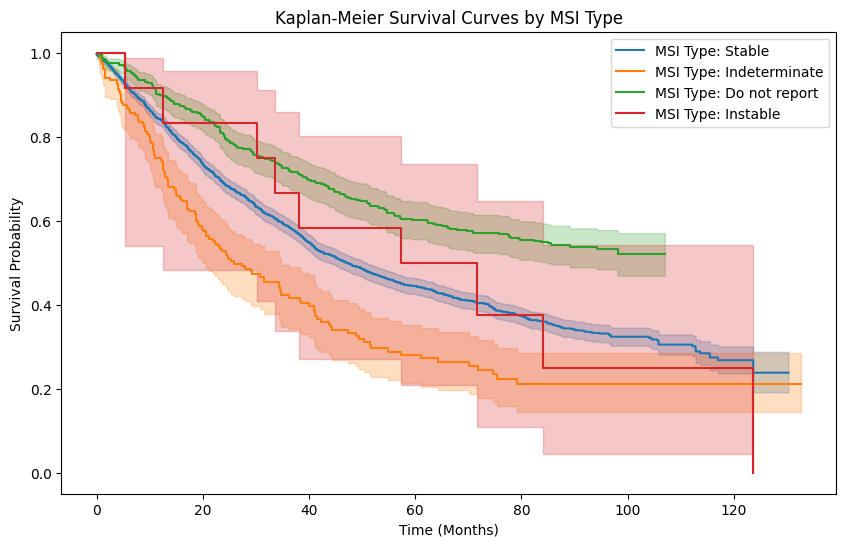


Jumlah sampel per MSI Type:
  Stable: 2926
  Indeterminate: 197
  Do not report: 520
  Instable: 13


In [97]:
# Buat Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Cek nilai unik MSI Type
print("Nilai unik di kolom 'MSI Type':")
print(df['MSI Type'].unique())

# Pisahkan data berdasarkan MSI Type
msi_groups = df['MSI Type'].unique()

# Buat plot
fig, ax = plt.subplots(figsize=(10, 6))

# Fit dan plot untuk setiap grup MSI Type
for msi_type in msi_groups:
    group_data = df[df['MSI Type'] == msi_type]
    kmf.fit(group_data['Overall Survival (Months)'], 
            group_data['Overall Survival Status'], 
            label=f'MSI Type: {msi_type}')
    kmf.plot(ax=ax)

# Tambahkan label dan judul
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curves by MSI Type')
plt.legend()
plt.show()

# Print jumlah sampel per kelompok
print("\nJumlah sampel per MSI Type:")
for msi_type in msi_groups:
    count = len(df[df['MSI Type'] == msi_type])
    print(f"  {msi_type}: {count}")

#### 3.2.1 Log Rank Test

In [98]:
# Prepare data untuk multivariate log-rank test
msi_result = multivariate_logrank_test(
    df['Overall Survival (Months)'],
    df['MSI Type'],
    df['Overall Survival Status']
)

print("\n" + "=" * 60)
print("LOG-RANK TEST: Perbandingan antar MSI Type")
print("=" * 60)
print(f"Test Statistic: {msi_result.test_statistic:.4f}")
print(f"P-value: {msi_result.p_value:.4f}")
print(f"Degrees of Freedom: {msi_result.degrees_of_freedom}")

if msi_result.p_value < 0.05:
    print("Kesimpulan: Terdapat perbedaan signifikan antara kurva survival MSI Type (p < 0.05)")
else:
    print("Kesimpulan: Tidak terdapat perbedaan signifikan antara kurva survival MSI Type (p >= 0.05)")


LOG-RANK TEST: Perbandingan antar MSI Type
Test Statistic: 87.5085
P-value: 0.0000
Degrees of Freedom: 3
Kesimpulan: Terdapat perbedaan signifikan antara kurva survival MSI Type (p < 0.05)


#### 3.2.2 Pairwise Log Rank Test

In [99]:
# Pairwise log-rank tests untuk melihat perbedaan antar grup
print("\n" + "=" * 60)
print("PAIRWISE LOG-RANK TESTS")
print("=" * 60)

msi_types_list = list(msi_groups)
for i in range(len(msi_types_list)):
    for j in range(i+1, len(msi_types_list)):
        msi1 = msi_types_list[i]
        msi2 = msi_types_list[j]
        
        group1 = df[df['MSI Type'] == msi1]
        group2 = df[df['MSI Type'] == msi2]
        
        result = logrank_test(
            group1['Overall Survival (Months)'],
            group2['Overall Survival (Months)'],
            group1['Overall Survival Status'],
            group2['Overall Survival Status']
        )
        
        print(f"\n{msi1} vs {msi2}:")
        print(f"  Test Statistic: {result.test_statistic:.4f}")
        print(f"  P-value: {result.p_value:.4f}")
        
        if result.p_value < 0.05:
            print(f"  Signifikan (p < 0.05)")
        else:
            print(f"  Tidak signifikan (p >= 0.05)")


PAIRWISE LOG-RANK TESTS

Stable vs Indeterminate:
  Test Statistic: 24.0553
  P-value: 0.0000
  Signifikan (p < 0.05)

Stable vs Do not report:
  Test Statistic: 55.7862
  P-value: 0.0000
  Signifikan (p < 0.05)

Stable vs Instable:
  Test Statistic: 0.0061
  P-value: 0.9376
  Tidak signifikan (p >= 0.05)

Indeterminate vs Do not report:
  Test Statistic: 78.2772
  P-value: 0.0000
  Signifikan (p < 0.05)

Indeterminate vs Instable:
  Test Statistic: 1.3669
  P-value: 0.2423
  Tidak signifikan (p >= 0.05)

Do not report vs Instable:
  Test Statistic: 1.6442
  P-value: 0.1997
  Tidak signifikan (p >= 0.05)


### 3.3 Overall Survival Curve

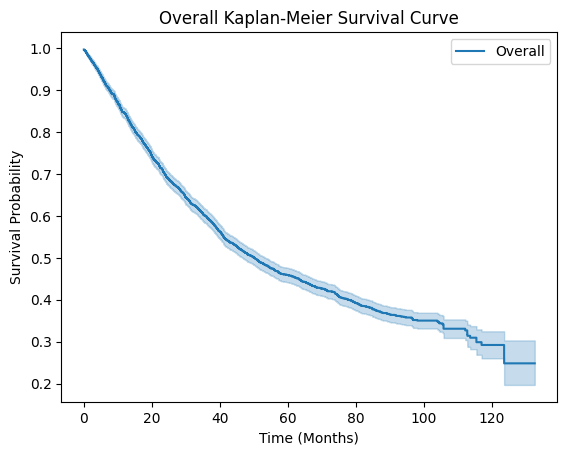

Median Survival Time (Overall): 50.13643686 months


In [100]:
# Overall Kaplan-Meier Survival Curve
kmf_overall = KaplanMeierFitter()
kmf_overall.fit(df['Overall Survival (Months)'], df['Overall Survival Status'], label='Overall')
kmf_overall.plot()
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('Overall Kaplan-Meier Survival Curve')
plt.show()

# Median survival time overall
median_overall = kmf_overall.median_survival_time_
print(f"Median Survival Time (Overall): {median_overall} months")

### 3.4 Median Survival Times

In [101]:
# Median survival times per group
kmf_male = KaplanMeierFitter()
kmf_male.fit(male['Overall Survival (Months)'], male['Overall Survival Status'])

kmf_female = KaplanMeierFitter()
kmf_female.fit(female['Overall Survival (Months)'], female['Overall Survival Status'])

median_male = kmf_male.median_survival_time_
median_female = kmf_female.median_survival_time_

print(f"Median Survival Time (Male): {median_male} months")
print(f"Median Survival Time (Female): {median_female} months")
print(f"Median Survival Time (Overall): {median_overall} months")

Median Survival Time (Male): 30.70651281 months
Median Survival Time (Female): 50.39944768 months
Median Survival Time (Overall): 50.13643686 months


### 3.5 Survival Probability at Specific Time

In [102]:
# Contoh: Probabilitas survival pada 12 bulan
time_point = 12  # Ganti dengan n bulan yang diinginkan

# Untuk overall
prob_overall = kmf_overall.predict(time_point)
print(f"Survival Probability at {time_point} months (Overall): {prob_overall}")

# Untuk Male
prob_male = kmf_male.predict(time_point)
print(f"Survival Probability at {time_point} months (Male): {prob_male}")

# Untuk Female
prob_female = kmf_female.predict(time_point)
print(f"Survival Probability at {time_point} months (Female): {prob_female}")

Survival Probability at 12 months (Overall): 0.8451867034300574
Survival Probability at 12 months (Male): 0.8901098901098903
Survival Probability at 12 months (Female): 0.844821080945139


### 3.6 Life Table

In [103]:
### Kaplan-Meier Life Table at Specific Times (Overall)
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]

# Buat list untuk tabel
table_data = []
for time in time_points:
    survival_prob = kmf_overall.predict(time)
    at_risk = sum(df['Overall Survival (Months)'] >= time)
    deaths_cumulative = sum((df['Overall Survival (Months)'] <= time) & (df['Overall Survival Status'] == 1))
    table_data.append({
        'Time (Months)': time,
        'At Risk': at_risk,
        'Deaths (Observed, Cumulative)': deaths_cumulative,
        'Survival Probability': survival_prob
    })

# Buat DataFrame
life_table_specific = pd.DataFrame(table_data)

# Tampilkan tabel
print("Kaplan-Meier Life Table at Specific Times (Overall):")
life_table_specific

# save to excel
life_table_specific.to_excel('kaplan_meier_life_table_overall.xlsx', index=False)

Kaplan-Meier Life Table at Specific Times (Overall):


# 4. Cox Regression

## 4.1 Pemodelan Cox Regression (Full)

In [104]:
# Pilih kolom yang diperlukan
columns_needed = [
    'Overall Survival (Months)',
    'Overall Survival Status',
    'Sex',
    'Primary Tumor Site',
    'MSI Type',
    'Mutation Count',
    'Fraction Genome Altered'
]

# Buat subset data (sudah drop NaN di preprocessing)
data_cox = df[columns_needed]

# Pastikan tipe data benar
data_cox = data_cox.copy()  # Buat copy untuk menghindari SettingWithCopyWarning
data_cox['Overall Survival (Months)'] = data_cox['Overall Survival (Months)'].astype(float)
data_cox['Overall Survival Status'] = data_cox['Overall Survival Status'].astype(int)

# Encode kolom kategorikal ke dummy variables
# Untuk MSI Type, gunakan MSI-Stable sebagai referensi
# Untuk variabel lain, gunakan drop_first=True (default)
data_cox_encoded = pd.get_dummies(data_cox, columns=['Primary Tumor Site', 'Sex'], drop_first=True)

# Untuk MSI Type, buat dummy variables dan drop 'MSI-Stable' sebagai referensi
msi_dummies = pd.get_dummies(data_cox['MSI Type'], prefix='MSI Type', drop_first=False)

# Drop kolom 'MSI Type_Stable' untuk menjadikannya sebagai referensi (baseline)
if 'MSI Type_Stable' in msi_dummies.columns:
    msi_dummies = msi_dummies.drop('MSI Type_Stable', axis=1)
    print("MSI Type referensi: Stable")
else:
    # Jika tidak ada MSI-Stable, coba cari nama kolom yang mirip
    print("Kolom MSI Type yang tersedia:")
    print(msi_dummies.columns.tolist())

# Drop kolom 'MSI Type' yang asli dari data_cox_encoded
if 'MSI Type' in data_cox_encoded.columns:
    data_cox_encoded = data_cox_encoded.drop('MSI Type', axis=1)

# Gabungkan dengan data_cox_encoded
data_cox_encoded = pd.concat([data_cox_encoded, msi_dummies], axis=1)

# Tampilkan info data setelah encoding
print(f"\nJumlah sampel setelah encoding: {len(data_cox_encoded)}")
print("Kolom setelah encoding:")
print(data_cox_encoded.columns.tolist())

# Fit model Cox Proportional Hazards
cph = CoxPHFitter(penalizer=0.1)  # Tambahkan penalizer untuk mengatasi kolinearitas
cph.fit(data_cox_encoded, duration_col='Overall Survival (Months)', event_col='Overall Survival Status')

# Tampilkan summary model
print("\nSummary Model Cox:")
print(cph.summary)

MSI Type referensi: Stable

Jumlah sampel setelah encoding: 3656
Kolom setelah encoding:
['Overall Survival (Months)', 'Overall Survival Status', 'Mutation Count', 'Fraction Genome Altered', 'Primary Tumor Site_Cancer of unknown primary', 'Sex_Male', 'MSI Type_Do not report', 'MSI Type_Indeterminate', 'MSI Type_Instable']

Summary Model Cox:
                                                  coef  exp(coef)  se(coef)  \
covariate                                                                     
Mutation Count                                0.011837   1.011907  0.002178   
Fraction Genome Altered                       1.279979   3.596563  0.109699   
Primary Tumor Site_Cancer of unknown primary  1.195200   3.304218  1.010468   
Sex_Male                                      0.270989   1.311260  0.213492   
MSI Type_Do not report                       -0.416992   0.659026  0.063370   
MSI Type_Indeterminate                        0.087810   1.091781  0.089348   
MSI Type_Instable       

In [105]:
# Lihat nilai unik di kolom kategorikal
print("Nilai unik di 'Primary Tumor Site':")
print(data_cox['Primary Tumor Site'].unique())

print("\nNilai unik di 'MSI Type':")
print(data_cox['MSI Type'].unique())

print("\nNilai unik di 'Sex':")
print(data_cox['Sex'].unique())

Nilai unik di 'Primary Tumor Site':
['Breast' 'Cancer of unknown primary']

Nilai unik di 'MSI Type':
['Stable' 'Indeterminate' 'Do not report' 'Instable']

Nilai unik di 'Sex':
['Female' 'Male']


### 4.2 Assumption Testing  
Asumsi model awal dengan 7 variabel

In [106]:
# Uji asumsi proportional hazards
print("\nUji Asumsi Proportional Hazards:")
try:
    results = cph.check_assumptions(data_cox_encoded, p_value_threshold=0.05)
    print(results)
except Exception as e:
    print(f"Error dalam uji asumsi: {e}")


Uji Asumsi Proportional Hazards:
Proportional hazard assumption looks okay.
[]


In [107]:
result_all = proportional_hazard_test(cph, data_cox_encoded, time_transform='rank')
print("Proportional Hazard Test for All Data (time_transform='rank'):")
print(result_all)

Proportional Hazard Test for All Data (time_transform='rank'):
<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3656 total observations, 1609 right-censored observations>
         test_name = proportional_hazard_test

---
                                              test_statistic    p  -log2(p)
Fraction Genome Altered                                 0.00 0.97      0.04
MSI Type_Do not report                                  0.01 0.92      0.12
MSI Type_Indeterminate                                  1.65 0.20      2.33
MSI Type_Instable                                       1.35 0.25      2.02
Mutation Count                                          0.32 0.57      0.80
Primary Tumor Site_Cancer of unknown primary            0.28 0.60      0.74
Sex_Male                                                0.54 0.46      1.11


In [108]:
# Concordance index
c_index = cph.concordance_index_
print(f"Concordance Index: {c_index}")

Concordance Index: 0.6071029649443741


## 4.2 Model Cox Regression (Backward)

Dari model Cox di atas, terlihat beberapa variabel tidak signifikan (p-value > 0.05). Kita akan melakukan backward selection untuk mendapatkan model dengan semua variabel yang signifikan.

In [109]:
def backward_selection_cox(data, duration_col, event_col, alpha=0.05):
    """
    Melakukan backward selection untuk model Cox Proportional Hazards
    
    Parameters:
    -----------
    data : DataFrame
        Data yang sudah di-encode
    duration_col : str
        Nama kolom durasi survival
    event_col : str
        Nama kolom event/status
    alpha : float
        Threshold p-value untuk signifikansi (default: 0.05)
    
    Returns:
    --------
    final_model : CoxPHFitter
        Model final hasil backward selection
    """
    
    # Ambil semua kolom prediktor (kecuali duration dan event)
    predictor_cols = [col for col in data.columns if col not in [duration_col, event_col]]
    current_predictors = predictor_cols.copy()
    
    iteration = 0
    print("=" * 80)
    print("BACKWARD SELECTION UNTUK COX PROPORTIONAL HAZARDS MODEL")
    print("=" * 80)
    print(f"\nJumlah variabel awal: {len(current_predictors)}")
    print(f"Alpha (threshold p-value): {alpha}\n")
    
    while True:
        iteration += 1
        print(f"\n{'=' * 80}")
        print(f"ITERASI {iteration}")
        print(f"{'=' * 80}")
        print(f"Jumlah variabel saat ini: {len(current_predictors)}")
        
        # Fit model dengan variabel saat ini
        data_current = data[[duration_col, event_col] + current_predictors].copy()
        
        cph_current = CoxPHFitter(penalizer=0.1)
        cph_current.fit(data_current, duration_col=duration_col, event_col=event_col)
        
        # Dapatkan p-values
        summary = cph_current.summary
        p_values = summary['p']
        
        # Tampilkan ringkasan
        print("\nRingkasan Model Saat Ini:")
        print("-" * 80)
        summary_display = summary[['coef', 'exp(coef)', 'se(coef)', 'z', 'p']].copy()
        summary_display = summary_display.sort_values('p', ascending=False)
        print(summary_display.to_string())
        
        # Cari variabel dengan p-value tertinggi
        max_p_value = p_values.max()
        max_p_var = p_values.idxmax()
        
        print(f"\n{'=' * 80}")
        print(f"Variabel dengan p-value tertinggi: {max_p_var}")
        print(f"P-value: {max_p_value:.6f}")
        
        # Jika semua variabel signifikan, berhenti
        if max_p_value <= alpha:
            print(f"\nSemua variabel signifikan (p-value <= {alpha})")
            print("=" * 80)
            print("\nBACKWARD SELECTION SELESAI!")
            print("=" * 80)
            return cph_current
        
        # Jika masih ada variabel tidak signifikan, hapus yang p-value tertinggi
        print(f"\nMenghapus variabel: {max_p_var} (p-value = {max_p_value:.6f} > {alpha})")
        current_predictors.remove(max_p_var)
        
        # Jika hanya tersisa 1 variabel atau kurang, berhenti
        if len(current_predictors) <= 1:
            print("\nHanya tersisa 1 variabel atau kurang. Menghentikan proses.")
            print("=" * 80)
            return cph_current

# Jalankan backward selection
final_cox_model = backward_selection_cox(
    data_cox_encoded, 
    duration_col='Overall Survival (Months)', 
    event_col='Overall Survival Status',
    alpha=0.05
)

BACKWARD SELECTION UNTUK COX PROPORTIONAL HAZARDS MODEL

Jumlah variabel awal: 7
Alpha (threshold p-value): 0.05


ITERASI 1
Jumlah variabel saat ini: 7

Ringkasan Model Saat Ini:
--------------------------------------------------------------------------------
                                                  coef  exp(coef)  se(coef)          z             p
covariate                                                                                           
MSI Type_Instable                            -0.203426   0.815930  0.313827  -0.648212  5.168478e-01
MSI Type_Indeterminate                        0.087810   1.091781  0.089348   0.982788  3.257118e-01
Primary Tumor Site_Cancer of unknown primary  1.195200   3.304218  1.010468   1.182819  2.368810e-01
Sex_Male                                      0.270989   1.311260  0.213492   1.269318  2.043276e-01
Mutation Count                                0.011837   1.011907  0.002178   5.435490  5.464590e-08
MSI Type_Do not report          

### 4.2.1 Ringkasan Model Final

In [110]:
# Tampilkan summary lengkap model final
print("=" * 80)
print("MODEL FINAL - COX PROPORTIONAL HAZARDS (SETELAH BACKWARD SELECTION)")
print("=" * 80)
print(final_cox_model.summary)

# Informasi tambahan
print("\n" + "=" * 80)
print("INFORMASI MODEL FINAL")
print("=" * 80)
print(f"Jumlah observasi: {final_cox_model.event_observed.shape[0]}")
print(f"Jumlah events: {final_cox_model.event_observed.sum()}")
print(f"Jumlah variabel prediktor: {len(final_cox_model.params_)}")
print(f"\nVariabel dalam model final:")
for i, var in enumerate(final_cox_model.params_.index, 1):
    print(f"  {i}. {var}")

MODEL FINAL - COX PROPORTIONAL HAZARDS (SETELAH BACKWARD SELECTION)
                             coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                
Mutation Count           0.011638   1.011706  0.002140        0.007444   
Fraction Genome Altered  1.309403   3.703963  0.105517        1.102594   
MSI Type_Do not report  -0.421629   0.655978  0.063181       -0.545461   

                         coef upper 95%  exp(coef) lower 95%  \
covariate                                                      
Mutation Count                 0.015832             1.007472   
Fraction Genome Altered        1.516213             3.011969   
MSI Type_Do not report        -0.297797             0.579575   

                         exp(coef) upper 95%  cmp to          z             p  \
covariate                                                                       
Mutation Count                      1.015958     0.0   5.438494  5.373286e-08 

### 4.2.2 Interpretasi Model Final

In [111]:
# Interpretasi Hazard Ratio
print("=" * 80)
print("INTERPRETASI HAZARD RATIO (HR)")
print("=" * 80)

summary_final = final_cox_model.summary
for var in summary_final.index:
    coef = summary_final.loc[var, 'coef']
    hr = summary_final.loc[var, 'exp(coef)']
    ci_lower = summary_final.loc[var, 'exp(coef) lower 95%']
    ci_upper = summary_final.loc[var, 'exp(coef) upper 95%']
    p_value = summary_final.loc[var, 'p']
    
    print(f"\n{var}:")
    print(f"  Coefficient: {coef:.4f}")
    print(f"  Hazard Ratio: {hr:.4f}")
    print(f"  95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"  P-value: {p_value:.4f}")
    
    if hr > 1:
        peningkatan = (hr - 1) * 100
        print(f"  Interpretasi: Meningkatkan risiko kematian sebesar {peningkatan:.2f}%")
    else:
        penurunan = (1 - hr) * 100
        print(f"  Interpretasi: Menurunkan risiko kematian sebesar {penurunan:.2f}%")

INTERPRETASI HAZARD RATIO (HR)

Mutation Count:
  Coefficient: 0.0116
  Hazard Ratio: 1.0117
  95% CI: [1.0075, 1.0160]
  P-value: 0.0000
  Interpretasi: Meningkatkan risiko kematian sebesar 1.17%

Fraction Genome Altered:
  Coefficient: 1.3094
  Hazard Ratio: 3.7040
  95% CI: [3.0120, 4.5549]
  P-value: 0.0000
  Interpretasi: Meningkatkan risiko kematian sebesar 270.40%

MSI Type_Do not report:
  Coefficient: -0.4216
  Hazard Ratio: 0.6560
  95% CI: [0.5796, 0.7425]
  P-value: 0.0000
  Interpretasi: Menurunkan risiko kematian sebesar 34.40%


### 4.2.3 Perbandingan Model Awal vs Model Final

In [112]:
# Perbandingan metrik model
print("=" * 80)
print("PERBANDINGAN MODEL AWAL VS MODEL FINAL")
print("=" * 80)

# Model awal (semua variabel)
print("\nMODEL AWAL (Semua Variabel):")
print(f"  Jumlah variabel: {len(cph.params_)}")
print(f"  AIC Partial: {cph.AIC_partial_:.4f}")
print(f"  Concordance Index: {cph.concordance_index_:.4f}")
print(f"  Log-likelihood: {cph.log_likelihood_:.4f}")

# Model final (setelah backward selection)
print("\nMODEL FINAL (Setelah Backward Selection):")
print(f"  Jumlah variabel: {len(final_cox_model.params_)}")
print(f"  AIC Partial: {final_cox_model.AIC_partial_:.4f}")
print(f"  Concordance Index: {final_cox_model.concordance_index_:.4f}")
print(f"  Log-likelihood: {final_cox_model.log_likelihood_:.4f}")

# Perbandingan
print("\nPERBANDINGAN:")
print(f"  Selisih AIC Partial: {final_cox_model.AIC_partial_ - cph.AIC_partial_:.4f}")
print(f"    (Nilai negatif = model final lebih baik)")
print(f"  Selisih Concordance: {final_cox_model.concordance_index_ - cph.concordance_index_:.4f}")
print(f"    (Nilai positif = model final lebih baik)")
print(f"  Variabel yang dihapus: {len(cph.params_) - len(final_cox_model.params_)}")

PERBANDINGAN MODEL AWAL VS MODEL FINAL

MODEL AWAL (Semua Variabel):
  Jumlah variabel: 7
  AIC Partial: 31067.2267
  Concordance Index: 0.6071
  Log-likelihood: -15526.6133

MODEL FINAL (Setelah Backward Selection):
  Jumlah variabel: 3
  AIC Partial: 31063.1178
  Concordance Index: 0.6059
  Log-likelihood: -15528.5589

PERBANDINGAN:
  Selisih AIC Partial: -4.1089
    (Nilai negatif = model final lebih baik)
  Selisih Concordance: -0.0012
    (Nilai positif = model final lebih baik)
  Variabel yang dihapus: 4


### 4.2.4 Visualisasi Model Final

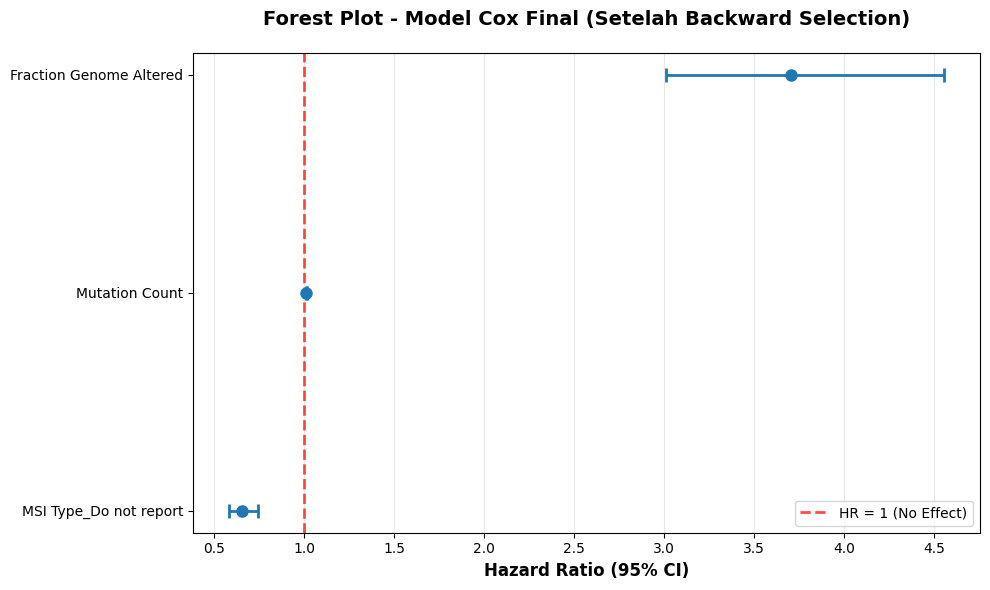


Interpretasi Forest Plot:
- Titik = Hazard Ratio
- Garis horizontal = 95% Confidence Interval
- HR > 1 (kanan garis merah) = Meningkatkan risiko kematian
- HR < 1 (kiri garis merah) = Menurunkan risiko kematian


In [113]:
# Plot hazard ratio dengan confidence interval
fig, ax = plt.subplots(figsize=(10, max(6, len(final_cox_model.params_) * 0.5)))

summary_final = final_cox_model.summary
vars_sorted = summary_final.sort_values('exp(coef)').index

y_pos = np.arange(len(vars_sorted))
hrs = summary_final.loc[vars_sorted, 'exp(coef)']
ci_lower = summary_final.loc[vars_sorted, 'exp(coef) lower 95%']
ci_upper = summary_final.loc[vars_sorted, 'exp(coef) upper 95%']

# Plot points dan error bars
ax.errorbar(hrs, y_pos, xerr=[hrs - ci_lower, ci_upper - hrs], 
            fmt='o', markersize=8, capsize=5, capthick=2, linewidth=2)

# Garis referensi di HR = 1
ax.axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.7, label='HR = 1 (No Effect)')

# Format
ax.set_yticks(y_pos)
ax.set_yticklabels(vars_sorted)
ax.set_xlabel('Hazard Ratio (95% CI)', fontsize=12, fontweight='bold')
ax.set_title('Forest Plot - Model Cox Final (Setelah Backward Selection)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("\nInterpretasi Forest Plot:")
print("- Titik = Hazard Ratio")
print("- Garis horizontal = 95% Confidence Interval")
print("- HR > 1 (kanan garis merah) = Meningkatkan risiko kematian")
print("- HR < 1 (kiri garis merah) = Menurunkan risiko kematian")

### 4.2.5 Uji Asumsi Proportional Hazards - Model Final

Setelah mendapatkan model final, kita perlu menguji apakah asumsi proportional hazards terpenuhi untuk semua variabel dalam model.

In [114]:
# Siapkan data untuk model final (hanya variabel yang tersisa)
final_predictors = list(final_cox_model.params_.index)
data_final = data_cox_encoded[['Overall Survival (Months)', 'Overall Survival Status'] + final_predictors].copy()

print("=" * 80)
print("UJI ASUMSI PROPORTIONAL HAZARDS - MODEL FINAL")
print("=" * 80)
print(f"\nJumlah variabel dalam model final: {len(final_predictors)}")
print("\nVariabel yang diuji:")
for i, var in enumerate(final_predictors, 1):
    print(f"  {i}. {var}")

UJI ASUMSI PROPORTIONAL HAZARDS - MODEL FINAL

Jumlah variabel dalam model final: 3

Variabel yang diuji:
  1. Mutation Count
  2. Fraction Genome Altered
  3. MSI Type_Do not report



CHECK ASSUMPTIONS - MODEL FINAL

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

Hasil Uji Asumsi:
--------------------------------------------------------------------------------

Variabel: Axes(0.0730035,0.155162;0.41329x0.744838)

Terjadi error saat uji asumsi: unsupported format string passed to Axes.__format__

Mencoba metode alternatif...


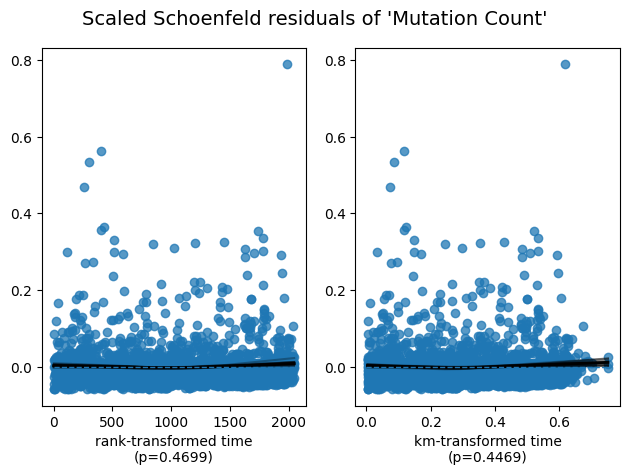

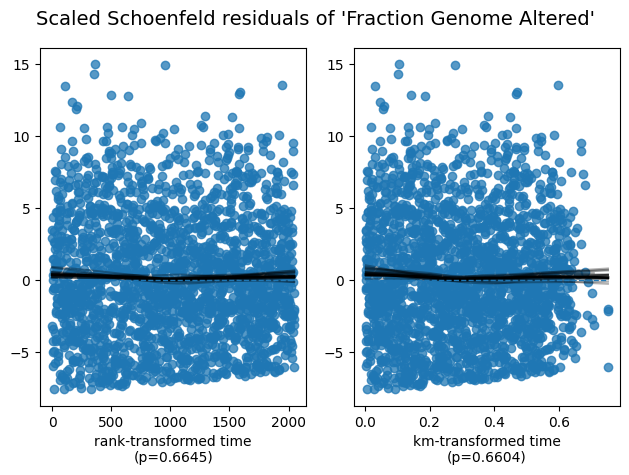

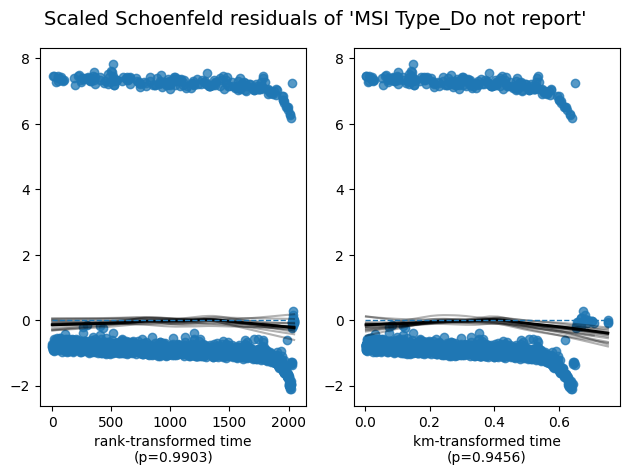

In [115]:
# Check Assumptions menggunakan metode built-in
print("\n" + "=" * 80)
print("CHECK ASSUMPTIONS - MODEL FINAL")
print("=" * 80)

try:
    results_final = final_cox_model.check_assumptions(data_final, p_value_threshold=0.05, show_plots=True)
    
    print("\nHasil Uji Asumsi:")
    print("-" * 80)
    
    # Cek setiap variabel
    for result in results_final:
        print(f"\nVariabel: {result[0]}")
        print(f"  Test statistic: {result[1]:.4f}")
        print(f"  P-value: {result[2]:.4f}")
        if result[2] < 0.05:
            print(f"  Status: TIDAK memenuhi asumsi proportional hazards (p < 0.05)")
        else:
            print(f"  Status: Memenuhi asumsi proportional hazards (p >= 0.05)")
            
except Exception as e:
    print(f"\nTerjadi error saat uji asumsi: {e}")
    print("\nMencoba metode alternatif...")

In [116]:
# Proportional Hazard Test menggunakan time_transform
print("\n" + "=" * 80)
print("PROPORTIONAL HAZARD TEST - MODEL FINAL")
print("=" * 80)

result_final = proportional_hazard_test(final_cox_model, data_final, time_transform='rank')

print("\nHasil Test (time_transform='rank'):")
print(result_final)

print("\n" + "=" * 80)
print("INTERPRETASI HASIL")
print("=" * 80)

# Interpretasi per variabel
test_results = result_final.summary
for idx in test_results.index:
    p_val = test_results.loc[idx, 'p']
    test_stat = test_results.loc[idx, 'test_statistic']
    
    print(f"\n{idx}:")
    print(f"  Test Statistic: {test_stat:.4f}")
    print(f"  P-value: {p_val:.4f}")
    
    if p_val < 0.05:
        print(f"  ❌ TIDAK memenuhi asumsi (p-value < 0.05)")
        print(f"     Variabel ini mungkin melanggar asumsi proportional hazards")
    else:
        print(f"  ✓ Memenuhi asumsi (p-value >= 0.05)")
        print(f"     Asumsi proportional hazards terpenuhi")

# Overall test
print("\n" + "=" * 80)
print("KESIMPULAN OVERALL")
print("=" * 80)

violations = test_results[test_results['p'] < 0.05]
if len(violations) == 0:
    print("\n✓ SEMUA variabel dalam model final memenuhi asumsi proportional hazards!")
    print("  Model dapat digunakan dengan confidence.")
else:
    print(f"\n❌ Terdapat {len(violations)} variabel yang melanggar asumsi:")
    for var in violations.index:
        print(f"  - {var} (p-value = {violations.loc[var, 'p']:.4f})")


PROPORTIONAL HAZARD TEST - MODEL FINAL

Hasil Test (time_transform='rank'):
<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3656 total observations, 1609 right-censored observations>
         test_name = proportional_hazard_test

---
                         test_statistic    p  -log2(p)
Fraction Genome Altered            0.19 0.66      0.59
MSI Type_Do not report             0.00 0.99      0.01
Mutation Count                     0.52 0.47      1.09

INTERPRETASI HASIL

Fraction Genome Altered:
  Test Statistic: 0.1881
  P-value: 0.6645
  ✓ Memenuhi asumsi (p-value >= 0.05)
     Asumsi proportional hazards terpenuhi

MSI Type_Do not report:
  Test Statistic: 0.0001
  P-value: 0.9903
  ✓ Memenuhi asumsi (p-value >= 0.05)
     Asumsi proportional hazards terpenuhi

Mutation Count:
  Test Statistic: 0.5222
  P-value: 0.4699
  ✓ Memenuhi asumsi

In [117]:
# Concordance Index Model Final
print("\n" + "=" * 80)
print("METRIK PERFORMA MODEL FINAL")
print("=" * 80)

c_index_final = final_cox_model.concordance_index_
print(f"\nConcordance Index: {c_index_final:.4f}")

print("\nInterpretasi Concordance Index:")
if c_index_final >= 0.7:
    print("  ✓ Baik (>= 0.7): Model memiliki kemampuan diskriminasi yang baik")
elif c_index_final >= 0.6:
    print("  ~ Cukup (0.6-0.7): Model memiliki kemampuan diskriminasi yang cukup")
else:
    print("  ❌ Kurang (< 0.6): Model memiliki kemampuan diskriminasi yang lemah")

print(f"\nAIC Partial: {final_cox_model.AIC_partial_:.4f}")
print(f"Log-likelihood: {final_cox_model.log_likelihood_:.4f}")


METRIK PERFORMA MODEL FINAL

Concordance Index: 0.6059

Interpretasi Concordance Index:
  ~ Cukup (0.6-0.7): Model memiliki kemampuan diskriminasi yang cukup

AIC Partial: 31063.1178
Log-likelihood: -15528.5589


### 4.2.7 Baseline Hazard $h_0$

In [118]:
# Ekstrak baseline hazard
baseline_hazard = final_cox_model.baseline_hazard_
print("Baseline Hazard Function h0(t):")
print(baseline_hazard)

Baseline Hazard Function h0(t):
            baseline hazard
0.000000           0.003127
0.065753           0.000539
0.098629           0.000539
0.131505           0.000539
0.164382           0.000270
...                     ...
129.302693         0.000000
129.434198         0.000000
130.223230         0.000000
130.288983         0.000000
132.656081         0.000000

[1858 rows x 1 columns]


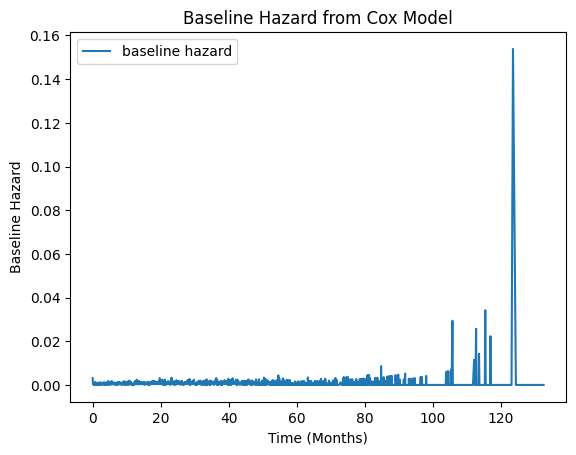

In [119]:
baseline_hazard.plot()
plt.xlabel('Time (Months)')
plt.ylabel('Baseline Hazard')
plt.title('Baseline Hazard from Cox Model')
plt.show()

In [120]:
# simpan baseline hazard ke file excel
baseline_hazard.to_excel('baseline_hazard.xlsx')

### Baseline Cumulative Hazard $H_0$

In [121]:
# Ekstrak baseline hazard cumulative
baseline_cumulative = final_cox_model.baseline_cumulative_hazard_
print("Baseline Hazard Cumulative Function h0(t):")
print(baseline_cumulative)

Baseline Hazard Cumulative Function h0(t):
            baseline cumulative hazard
0.000000                      0.003127
0.065753                      0.003666
0.098629                      0.004205
0.131505                      0.004744
0.164382                      0.005014
...                                ...
129.302693                    1.404144
129.434198                    1.404144
130.223230                    1.404144
130.288983                    1.404144
132.656081                    1.404144

[1858 rows x 1 columns]


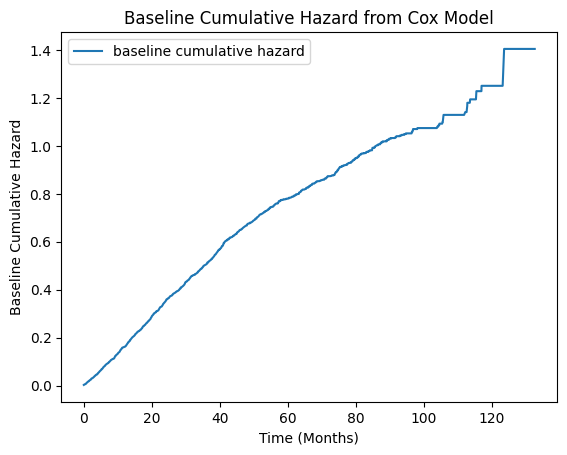

In [122]:
baseline_cumulative.plot()
plt.xlabel('Time (Months)')
plt.ylabel('Baseline Cumulative Hazard')
plt.title('Baseline Cumulative Hazard from Cox Model')
plt.show()

In [123]:
# simpan baseline hazard ke file excel
baseline_cumulative.to_excel('baseline_cumulative_hazard.xlsx')

## Cox Regression - MSI Type (Exc. Do Not Report)
Cox Regression hanya mengambil MSI Type kecuali 'Do Not Report'. Do Not Report akan menggangu hasil penelitian karena variabel ini adalah variabel yang tidak dilaporkan (atau bisa dianggap NuLL), akan tetapi tidak direkomendasikan untuk dihilangkan.  

Bukan sebagai analisis utama melainkan analisis tambahan untuk sensitivity. Memverifikasi apakah hubungan MSI (Stable/Instable/Intermediate) dengan survival tetap konsisten ketika kelompok "Do Not Report" yang heterogen dan mungkin "berisik" tidak disertakan.

### Persiapan Data 

In [124]:
# Filter data: Exclude MSI Type 'Do not report'
print("Jumlah data sebelum filtering:", len(df))
print("Distribusi MSI Type sebelum filtering:")
print(df['MSI Type'].value_counts())

df_msi = df[df['MSI Type'] != 'Do not report'].copy()

print("\n" + "=" * 60)
print("Jumlah data setelah filtering (exclude 'Do not report'):", len(df_msi))
print("Distribusi MSI Type setelah filtering:")
print(df_msi['MSI Type'].value_counts())
print("=" * 60)

Jumlah data sebelum filtering: 3656
Distribusi MSI Type sebelum filtering:
MSI Type
Stable           2926
Do not report     520
Indeterminate     197
Instable           13
Name: count, dtype: int64

Jumlah data setelah filtering (exclude 'Do not report'): 3136
Distribusi MSI Type setelah filtering:
MSI Type
Stable           2926
Indeterminate     197
Instable           13
Name: count, dtype: int64


### Pemodelan Cox Regression (Full) 

In [125]:
# Pilih kolom yang diperlukan
columns_needed_msi = [
    'Overall Survival (Months)',
    'Overall Survival Status',
    'Sex',
    'Primary Tumor Site',
    'MSI Type',
    'Mutation Count',
    'Fraction Genome Altered'
]

# Buat subset data
data_cox_msi = df_msi[columns_needed_msi].copy()

# Pastikan tipe data benar
data_cox_msi['Overall Survival (Months)'] = data_cox_msi['Overall Survival (Months)'].astype(float)
data_cox_msi['Overall Survival Status'] = data_cox_msi['Overall Survival Status'].astype(int)

# Encode kolom kategorikal ke dummy variables
# Untuk MSI Type, gunakan MSI-Stable sebagai referensi
# Untuk variabel lain, gunakan drop_first=True (default)
data_cox_msi_encoded = pd.get_dummies(data_cox_msi, columns=['Primary Tumor Site', 'Sex'], drop_first=True)

# Untuk MSI Type, buat dummy variables dan drop 'Stable' sebagai referensi (baseline)
msi_dummies_msi = pd.get_dummies(data_cox_msi['MSI Type'], prefix='MSI Type', drop_first=False)

# Drop kolom 'MSI Type_Stable' untuk menjadikannya sebagai referensi
if 'MSI Type_Stable' in msi_dummies_msi.columns:
    msi_dummies_msi = msi_dummies_msi.drop('MSI Type_Stable', axis=1)
    print("MSI Type referensi: Stable")
else:
    print("Kolom MSI Type yang tersedia:")
    print(msi_dummies_msi.columns.tolist())

# Drop kolom 'MSI Type' yang asli dari data_cox_msi_encoded
if 'MSI Type' in data_cox_msi_encoded.columns:
    data_cox_msi_encoded = data_cox_msi_encoded.drop('MSI Type', axis=1)

# Gabungkan dengan data_cox_msi_encoded
data_cox_msi_encoded = pd.concat([data_cox_msi_encoded, msi_dummies_msi], axis=1)

# Tampilkan info data setelah encoding
print(f"\nJumlah sampel setelah encoding: {len(data_cox_msi_encoded)}")
print("Kolom setelah encoding:")
print(data_cox_msi_encoded.columns.tolist())

# Fit model Cox Proportional Hazards
cph_msi = CoxPHFitter(penalizer=0.1)
cph_msi.fit(data_cox_msi_encoded, duration_col='Overall Survival (Months)', event_col='Overall Survival Status')

# Tampilkan summary model
print("\n" + "=" * 80)
print("SUMMARY MODEL COX - TANPA 'Do Not Report'")
print("=" * 80)
print(cph_msi.summary)

MSI Type referensi: Stable

Jumlah sampel setelah encoding: 3136
Kolom setelah encoding:
['Overall Survival (Months)', 'Overall Survival Status', 'Mutation Count', 'Fraction Genome Altered', 'Primary Tumor Site_Cancer of unknown primary', 'Sex_Male', 'MSI Type_Indeterminate', 'MSI Type_Instable']

SUMMARY MODEL COX - TANPA 'Do Not Report'
                                                  coef  exp(coef)  se(coef)  \
covariate                                                                     
Mutation Count                                0.010103   1.010154  0.002375   
Fraction Genome Altered                       1.159529   3.188430  0.117029   
Primary Tumor Site_Cancer of unknown primary  1.174600   3.236849  1.009479   
Sex_Male                                      0.277786   1.320203  0.219413   
MSI Type_Indeterminate                        0.107837   1.113866  0.090067   
MSI Type_Instable                            -0.168093   0.845276  0.314619   

                          

### Model Cox Regression (Backward Selection) 

In [126]:
# Jalankan backward selection untuk model tanpa 'Do Not Report'
final_cox_model_msi = backward_selection_cox(
    data_cox_msi_encoded, 
    duration_col='Overall Survival (Months)', 
    event_col='Overall Survival Status',
    alpha=0.05
)

BACKWARD SELECTION UNTUK COX PROPORTIONAL HAZARDS MODEL

Jumlah variabel awal: 6
Alpha (threshold p-value): 0.05


ITERASI 1
Jumlah variabel saat ini: 6

Ringkasan Model Saat Ini:
--------------------------------------------------------------------------------
                                                  coef  exp(coef)  se(coef)         z             p
covariate                                                                                          
MSI Type_Instable                            -0.168093   0.845276  0.314619 -0.534274  5.931522e-01
Primary Tumor Site_Cancer of unknown primary  1.174600   3.236849  1.009479  1.163571  2.445979e-01
MSI Type_Indeterminate                        0.107837   1.113866  0.090067  1.197301  2.311893e-01
Sex_Male                                      0.277786   1.320203  0.219413  1.266040  2.054988e-01
Mutation Count                                0.010103   1.010154  0.002375  4.254897  2.091454e-05
Fraction Genome Altered                

### Ringkasan Model Final 

In [127]:
# Tampilkan summary lengkap model final
print("=" * 80)
print("MODEL FINAL - COX PROPORTIONAL HAZARDS (TANPA 'Do Not Report')")
print("=" * 80)
print(final_cox_model_msi.summary)

# Informasi tambahan
print("\n" + "=" * 80)
print("INFORMASI MODEL FINAL")
print("=" * 80)
print(f"Jumlah observasi: {final_cox_model_msi.event_observed.shape[0]}")
print(f"Jumlah events: {final_cox_model_msi.event_observed.sum()}")
print(f"Jumlah variabel prediktor: {len(final_cox_model_msi.params_)}")
print(f"\nVariabel dalam model final:")
for i, var in enumerate(final_cox_model_msi.params_.index, 1):
    print(f"  {i}. {var}")
    
# Concordance Index
print(f"\nConcordance Index: {final_cox_model_msi.concordance_index_:.4f}")
print(f"AIC Partial: {final_cox_model_msi.AIC_partial_:.4f}")
print(f"Log-likelihood: {final_cox_model_msi.log_likelihood_:.4f}")

MODEL FINAL - COX PROPORTIONAL HAZARDS (TANPA 'Do Not Report')
                             coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                
Mutation Count           0.009973   1.010023  0.002329        0.005409   
Fraction Genome Altered  1.200429   3.321540  0.112008        0.980897   

                         coef upper 95%  exp(coef) lower 95%  \
covariate                                                      
Mutation Count                 0.014537             1.005424   
Fraction Genome Altered        1.419960             2.666847   

                         exp(coef) upper 95%  cmp to          z             p  \
covariate                                                                       
Mutation Count                      1.014643     0.0   4.283038  1.843590e-05   
Fraction Genome Altered             4.136956     0.0  10.717351  8.438563e-27   

                          -log2(p)  
covariate            

#### Interpretasi Hazard Ratio 

In [128]:
# Interpretasi Hazard Ratio untuk model tanpa 'Do Not Report'
print("=" * 80)
print("INTERPRETASI HAZARD RATIO (HR) - TANPA 'Do Not Report'")
print("=" * 80)

summary_final_msi = final_cox_model_msi.summary
for var in summary_final_msi.index:
    coef = summary_final_msi.loc[var, 'coef']
    hr = summary_final_msi.loc[var, 'exp(coef)']
    ci_lower = summary_final_msi.loc[var, 'exp(coef) lower 95%']
    ci_upper = summary_final_msi.loc[var, 'exp(coef) upper 95%']
    p_value = summary_final_msi.loc[var, 'p']
    
    print(f"\n{var}:")
    print(f"  Coefficient: {coef:.4f}")
    print(f"  Hazard Ratio: {hr:.4f}")
    print(f"  95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"  P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        signif = "SIGNIFIKAN ✓"
    else:
        signif = "Tidak signifikan"
    print(f"  Status: {signif}")
    
    if hr > 1:
        peningkatan = (hr - 1) * 100
        print(f"  Interpretasi: Meningkatkan risiko kematian sebesar {peningkatan:.2f}%")
    else:
        penurunan = (1 - hr) * 100
        print(f"  Interpretasi: Menurunkan risiko kematian sebesar {penurunan:.2f}%")

INTERPRETASI HAZARD RATIO (HR) - TANPA 'Do Not Report'

Mutation Count:
  Coefficient: 0.0100
  Hazard Ratio: 1.0100
  95% CI: [1.0054, 1.0146]
  P-value: 0.0000
  Status: SIGNIFIKAN ✓
  Interpretasi: Meningkatkan risiko kematian sebesar 1.00%

Fraction Genome Altered:
  Coefficient: 1.2004
  Hazard Ratio: 3.3215
  95% CI: [2.6668, 4.1370]
  P-value: 0.0000
  Status: SIGNIFIKAN ✓
  Interpretasi: Meningkatkan risiko kematian sebesar 232.15%


### Perbandingan Model dengan dan tanpa "Do Not Report"

In [129]:
# Perbandingan model dengan semua data vs tanpa 'Do Not Report'
print("=" * 80)
print("PERBANDINGAN MODEL: SEMUA DATA vs TANPA 'Do Not Report'")
print("=" * 80)

# Model dengan semua data
print("\nMODEL DENGAN SEMUA DATA (termasuk 'Do Not Report'):")
print(f"  Jumlah observasi: {final_cox_model.event_observed.shape[0]}")
print(f"  Jumlah variabel: {len(final_cox_model.params_)}")
print(f"  AIC Partial: {final_cox_model.AIC_partial_:.4f}")
print(f"  Concordance Index: {final_cox_model.concordance_index_:.4f}")
print(f"  Log-likelihood: {final_cox_model.log_likelihood_:.4f}")

# Model tanpa 'Do Not Report'
print("\nMODEL TANPA 'Do Not Report':")
print(f"  Jumlah observasi: {final_cox_model_msi.event_observed.shape[0]}")
print(f"  Jumlah variabel: {len(final_cox_model_msi.params_)}")
print(f"  AIC Partial: {final_cox_model_msi.AIC_partial_:.4f}")
print(f"  Concordance Index: {final_cox_model_msi.concordance_index_:.4f}")
print(f"  Log-likelihood: {final_cox_model_msi.log_likelihood_:.4f}")

# Perbandingan
print("\nPERBANDINGAN:")
print(f"  Selisih observasi: {final_cox_model.event_observed.shape[0] - final_cox_model_msi.event_observed.shape[0]}")
print(f"  Selisih Concordance: {final_cox_model_msi.concordance_index_ - final_cox_model.concordance_index_:.4f}")
print(f"    (Nilai positif = model tanpa 'Do Not Report' lebih baik)")

print("\n" + "=" * 80)
print("VARIABEL MSI TYPE DALAM MODEL FINAL")
print("=" * 80)

print("\nModel dengan semua data:")
msi_vars_all = [var for var in final_cox_model.params_.index if 'MSI Type' in var]
if msi_vars_all:
    for var in msi_vars_all:
        hr = final_cox_model.summary.loc[var, 'exp(coef)']
        p_val = final_cox_model.summary.loc[var, 'p']
        print(f"  {var}: HR={hr:.4f}, p={p_val:.4f}")
else:
    print("  Tidak ada variabel MSI Type yang signifikan")

print("\nModel tanpa 'Do Not Report':")
msi_vars_filtered = [var for var in final_cox_model_msi.params_.index if 'MSI Type' in var]
if msi_vars_filtered:
    for var in msi_vars_filtered:
        hr = final_cox_model_msi.summary.loc[var, 'exp(coef)']
        p_val = final_cox_model_msi.summary.loc[var, 'p']
        print(f"  {var}: HR={hr:.4f}, p={p_val:.4f}")
else:
    print("  Tidak ada variabel MSI Type yang signifikan")

PERBANDINGAN MODEL: SEMUA DATA vs TANPA 'Do Not Report'

MODEL DENGAN SEMUA DATA (termasuk 'Do Not Report'):
  Jumlah observasi: 3656
  Jumlah variabel: 3
  AIC Partial: 31063.1178
  Concordance Index: 0.6059
  Log-likelihood: -15528.5589

MODEL TANPA 'Do Not Report':
  Jumlah observasi: 3136
  Jumlah variabel: 2
  AIC Partial: 27191.8572
  Concordance Index: 0.5873
  Log-likelihood: -13593.9286

PERBANDINGAN:
  Selisih observasi: 520
  Selisih Concordance: -0.0186
    (Nilai positif = model tanpa 'Do Not Report' lebih baik)

VARIABEL MSI TYPE DALAM MODEL FINAL

Model dengan semua data:
  MSI Type_Do not report: HR=0.6560, p=0.0000

Model tanpa 'Do Not Report':
  Tidak ada variabel MSI Type yang signifikan


## Cox Regression - MSI Report & Do Not Report

Analisis tambahan dengan mengelompokkan MSI Type menjadi dua kategori biner:
- **MSI Report**: Stable, Instable, dan Intermediate (kategori referensi)
- **MSI Do Not Report**: Do Not Report sebagai variabel prediktor

Pendekatan ini dilakukan karena temuan signifikansi "Do Not Report" dalam model sebelumnya, untuk mengisolasi efek dari kelompok "Do Not Report" terhadap survival.

### Persiapan Data - Binarisasi MSI Type

In [130]:
# Buat variabel biner MSI Report vs Do Not Report
print("=" * 80)
print("BINARISASI MSI TYPE: REPORT vs DO NOT REPORT")
print("=" * 80)

# Cek distribusi awal
print("\nDistribusi MSI Type awal:")
print(df['MSI Type'].value_counts())

# Buat variabel biner baru
df_binary = df.copy()
df_binary['MSI_Binary'] = df_binary['MSI Type'].apply(
    lambda x: 'Do Not Report' if x == 'Do not report' else 'Report'
)

print("\n" + "=" * 80)
print("Distribusi MSI Binary:")
print(df_binary['MSI_Binary'].value_counts())
print("=" * 80)

# Verifikasi mapping
print("\nVerifikasi Mapping:")
print("MSI Type -> MSI Binary:")
for msi_type in df['MSI Type'].unique():
    binary_val = 'Do Not Report' if msi_type == 'Do not report' else 'Report'
    count = len(df_binary[df_binary['MSI Type'] == msi_type])
    print(f"  {msi_type:20} -> {binary_val:20} (n={count})")

print(f"\nTotal sampel: {len(df_binary)}")

BINARISASI MSI TYPE: REPORT vs DO NOT REPORT

Distribusi MSI Type awal:
MSI Type
Stable           2926
Do not report     520
Indeterminate     197
Instable           13
Name: count, dtype: int64

Distribusi MSI Binary:
MSI_Binary
Report           3136
Do Not Report     520
Name: count, dtype: int64

Verifikasi Mapping:
MSI Type -> MSI Binary:
  Stable               -> Report               (n=2926)
  Indeterminate        -> Report               (n=197)
  Do not report        -> Do Not Report        (n=520)
  Instable             -> Report               (n=13)

Total sampel: 3656


### Pemodelan Cox Regression (Full) dengan MSI Binary

In [131]:
# Import ulang data untuk memastikan tidak ada error tipe data
df_binary_fresh = pd.read_csv('breast_msk_2025_clinical_data.tsv', sep='\t')

# Preprocessing ulang
df_binary_fresh['Sex'] = df_binary_fresh['Sex'].str.capitalize()
df_binary_fresh = df_binary_fresh[df_binary_fresh['Sex'].isin(['Male', 'Female'])]
df_binary_fresh['Overall Survival Status'] = df_binary_fresh['Overall Survival Status'].map({'1:DECEASED': 1, '0:LIVING': 0})
df_binary_fresh['Primary Tumor Site'] = df_binary_fresh['Primary Tumor Site'].str.capitalize()

# Drop NaN
columns_needed_binary_full = [
    'Overall Survival (Months)',
    'Overall Survival Status',
    'Sex',
    'Primary Tumor Site',
    'MSI Type',
    'Mutation Count',
    'Fraction Genome Altered'
]
df_binary_fresh = df_binary_fresh.dropna(subset=columns_needed_binary_full)

# Buat variabel MSI Binary
df_binary_fresh['MSI_Binary'] = df_binary_fresh['MSI Type'].apply(
    lambda x: 'Do Not Report' if x == 'Do not report' else 'Report'
)

# Pilih kolom yang diperlukan
columns_needed_binary = [
    'Overall Survival (Months)',
    'Overall Survival Status',
    'Sex',
    'Primary Tumor Site',
    'MSI_Binary',
    'Mutation Count',
    'Fraction Genome Altered'
]

# Buat subset data
data_cox_binary = df_binary_fresh[columns_needed_binary].copy()

# Pastikan tipe data benar
data_cox_binary['Overall Survival (Months)'] = data_cox_binary['Overall Survival (Months)'].astype(float)
data_cox_binary['Overall Survival Status'] = data_cox_binary['Overall Survival Status'].astype(int)

# Encode kolom kategorikal ke dummy variables
# Primary Tumor Site dan Sex menggunakan drop_first=True
data_cox_binary_encoded = pd.get_dummies(data_cox_binary, columns=['Primary Tumor Site', 'Sex'], drop_first=True)

# Untuk MSI_Binary, buat dummy dan gunakan 'Report' sebagai referensi (drop it)
msi_binary_dummies = pd.get_dummies(data_cox_binary['MSI_Binary'], prefix='MSI', drop_first=False)

# Drop 'MSI_Report' untuk menjadikannya referensi
if 'MSI_Report' in msi_binary_dummies.columns:
    msi_binary_dummies = msi_binary_dummies.drop('MSI_Report', axis=1)
    print("MSI Binary referensi: Report (Stable + Instable + Intermediate)")
else:
    print("Kolom MSI Binary yang tersedia:")
    print(msi_binary_dummies.columns.tolist())

# Drop kolom 'MSI_Binary' yang asli
if 'MSI_Binary' in data_cox_binary_encoded.columns:
    data_cox_binary_encoded = data_cox_binary_encoded.drop('MSI_Binary', axis=1)

# Gabungkan dengan data_cox_binary_encoded
data_cox_binary_encoded = pd.concat([data_cox_binary_encoded, msi_binary_dummies], axis=1)

# Tampilkan info data setelah encoding
print(f"\nJumlah sampel setelah encoding: {len(data_cox_binary_encoded)}")
print("\nKolom setelah encoding:")
for i, col in enumerate(data_cox_binary_encoded.columns.tolist(), 1):
    print(f"  {i}. {col}")

# Fit model Cox Proportional Hazards
cph_binary = CoxPHFitter(penalizer=0.1)
cph_binary.fit(data_cox_binary_encoded, duration_col='Overall Survival (Months)', event_col='Overall Survival Status')

# Tampilkan summary model
print("\n" + "=" * 80)
print("SUMMARY MODEL COX - MSI BINARY (REPORT vs DO NOT REPORT)")
print("=" * 80)
print(cph_binary.summary)

MSI Binary referensi: Report (Stable + Instable + Intermediate)

Jumlah sampel setelah encoding: 3656

Kolom setelah encoding:
  1. Overall Survival (Months)
  2. Overall Survival Status
  3. Mutation Count
  4. Fraction Genome Altered
  5. Primary Tumor Site_Cancer of unknown primary
  6. Sex_Male
  7. MSI_Do Not Report

SUMMARY MODEL COX - MSI BINARY (REPORT vs DO NOT REPORT)
                                                  coef  exp(coef)  se(coef)  \
covariate                                                                     
Mutation Count                                0.011601   1.011669  0.002143   
Fraction Genome Altered                       1.309777   3.705347  0.105568   
Primary Tumor Site_Cancer of unknown primary  1.193983   3.300201  1.010394   
Sex_Male                                      0.267077   1.306141  0.213358   
MSI_Do Not Report                            -0.420547   0.656688  0.063192   

                                              coef lower 95%  coe

### Model Cox Regression (Backward Selection)

In [132]:
# Jalankan backward selection untuk model dengan MSI Binary
final_cox_model_binary = backward_selection_cox(
    data_cox_binary_encoded, 
    duration_col='Overall Survival (Months)', 
    event_col='Overall Survival Status',
    alpha=0.05
)

BACKWARD SELECTION UNTUK COX PROPORTIONAL HAZARDS MODEL

Jumlah variabel awal: 5
Alpha (threshold p-value): 0.05


ITERASI 1
Jumlah variabel saat ini: 5

Ringkasan Model Saat Ini:
--------------------------------------------------------------------------------
                                                  coef  exp(coef)  se(coef)          z             p
covariate                                                                                           
Primary Tumor Site_Cancer of unknown primary  1.193983   3.300201  1.010394   1.181701  2.373244e-01
Sex_Male                                      0.267077   1.306141  0.213358   1.251774  2.106521e-01
Mutation Count                                0.011601   1.011669  0.002143   5.412582  6.212251e-08
MSI_Do Not Report                            -0.420547   0.656688  0.063192  -6.655015  2.832703e-11
Fraction Genome Altered                       1.309777   3.705347  0.105568  12.406951  2.396054e-35

Variabel dengan p-value terting

### Ringkasan Model Final (MSI Binary)

In [133]:
# Tampilkan summary lengkap model final dengan MSI Binary
print("=" * 80)
print("MODEL FINAL - COX PH (MSI BINARY: REPORT vs DO NOT REPORT)")
print("=" * 80)
print(final_cox_model_binary.summary)

# Informasi tambahan
print("\n" + "=" * 80)
print("INFORMASI MODEL FINAL")
print("=" * 80)
print(f"Jumlah observasi: {final_cox_model_binary.event_observed.shape[0]}")
print(f"Jumlah events: {final_cox_model_binary.event_observed.sum()}")
print(f"Jumlah variabel prediktor: {len(final_cox_model_binary.params_)}")
print(f"\nVariabel dalam model final:")
for i, var in enumerate(final_cox_model_binary.params_.index, 1):
    print(f"  {i}. {var}")
    
# Metrik performa
print("\n" + "=" * 80)
print("METRIK PERFORMA")
print("=" * 80)
print(f"Concordance Index: {final_cox_model_binary.concordance_index_:.4f}")
print(f"AIC Partial: {final_cox_model_binary.AIC_partial_:.4f}")
print(f"Log-likelihood: {final_cox_model_binary.log_likelihood_:.4f}")

MODEL FINAL - COX PH (MSI BINARY: REPORT vs DO NOT REPORT)
                             coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                
Mutation Count           0.011638   1.011706  0.002140        0.007444   
Fraction Genome Altered  1.309403   3.703963  0.105517        1.102594   
MSI_Do Not Report       -0.421629   0.655978  0.063181       -0.545461   

                         coef upper 95%  exp(coef) lower 95%  \
covariate                                                      
Mutation Count                 0.015832             1.007472   
Fraction Genome Altered        1.516213             3.011969   
MSI_Do Not Report             -0.297797             0.579575   

                         exp(coef) upper 95%  cmp to          z             p  \
covariate                                                                       
Mutation Count                      1.015958     0.0   5.438494  5.373286e-08   
Fracti

### Interpretasi Hazard Ratio (MSI Binary)

In [134]:
# Interpretasi Hazard Ratio untuk model dengan MSI Binary
print("=" * 80)
print("INTERPRETASI HAZARD RATIO (HR) - MSI BINARY")
print("=" * 80)

summary_final_binary = final_cox_model_binary.summary
for var in summary_final_binary.index:
    coef = summary_final_binary.loc[var, 'coef']
    hr = summary_final_binary.loc[var, 'exp(coef)']
    ci_lower = summary_final_binary.loc[var, 'exp(coef) lower 95%']
    ci_upper = summary_final_binary.loc[var, 'exp(coef) upper 95%']
    p_value = summary_final_binary.loc[var, 'p']
    
    print(f"\n{var}:")
    print(f"  Coefficient: {coef:.4f}")
    print(f"  Hazard Ratio: {hr:.4f}")
    print(f"  95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"  P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        signif = "✓ SIGNIFIKAN"
    else:
        signif = "Tidak signifikan"
    print(f"  Status: {signif}")
    
    if hr > 1:
        peningkatan = (hr - 1) * 100
        print(f"  Interpretasi: Meningkatkan risiko kematian sebesar {peningkatan:.2f}%")
    else:
        penurunan = (1 - hr) * 100
        print(f"  Interpretasi: Menurunkan risiko kematian sebesar {penurunan:.2f}%")

# Fokus pada MSI Do Not Report
print("\n" + "=" * 80)
print("FOKUS: MSI DO NOT REPORT")
print("=" * 80)

if 'MSI_Do Not Report' in summary_final_binary.index:
    var = 'MSI_Do Not Report'
    hr = summary_final_binary.loc[var, 'exp(coef)']
    ci_lower = summary_final_binary.loc[var, 'exp(coef) lower 95%']
    ci_upper = summary_final_binary.loc[var, 'exp(coef) upper 95%']
    p_value = summary_final_binary.loc[var, 'p']
    
    print(f"\nHazard Ratio: {hr:.4f}")
    print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"P-value: {p_value:.4f}")
    
    print("\nReferensi: MSI Report (Stable + Instable + Intermediate)")
    if hr > 1:
        peningkatan = (hr - 1) * 100
        print(f"\nPasien dengan MSI 'Do Not Report' memiliki risiko kematian")
        print(f"{peningkatan:.2f}% LEBIH TINGGI dibandingkan pasien dengan MSI Report")
    else:
        penurunan = (1 - hr) * 100
        print(f"\nPasien dengan MSI 'Do Not Report' memiliki risiko kematian")
        print(f"{penurunan:.2f}% LEBIH RENDAH dibandingkan pasien dengan MSI Report")
else:
    print("\nVariabel 'MSI_Do Not Report' tidak ada dalam model final")
    print("Variabel ini mungkin dihapus dalam proses backward selection")

INTERPRETASI HAZARD RATIO (HR) - MSI BINARY

Mutation Count:
  Coefficient: 0.0116
  Hazard Ratio: 1.0117
  95% CI: [1.0075, 1.0160]
  P-value: 0.0000
  Status: ✓ SIGNIFIKAN
  Interpretasi: Meningkatkan risiko kematian sebesar 1.17%

Fraction Genome Altered:
  Coefficient: 1.3094
  Hazard Ratio: 3.7040
  95% CI: [3.0120, 4.5549]
  P-value: 0.0000
  Status: ✓ SIGNIFIKAN
  Interpretasi: Meningkatkan risiko kematian sebesar 270.40%

MSI_Do Not Report:
  Coefficient: -0.4216
  Hazard Ratio: 0.6560
  95% CI: [0.5796, 0.7425]
  P-value: 0.0000
  Status: ✓ SIGNIFIKAN
  Interpretasi: Menurunkan risiko kematian sebesar 34.40%

FOKUS: MSI DO NOT REPORT

Hazard Ratio: 0.6560
95% CI: [0.5796, 0.7425]
P-value: 0.0000

Referensi: MSI Report (Stable + Instable + Intermediate)

Pasien dengan MSI 'Do Not Report' memiliki risiko kematian
34.40% LEBIH RENDAH dibandingkan pasien dengan MSI Report


### Perbandingan Model: Original vs Binary MSI

In [135]:
# Perbandingan model original (4 kategori MSI) vs binary MSI
print("=" * 80)
print("PERBANDINGAN MODEL: ORIGINAL MSI vs BINARY MSI")
print("=" * 80)

# Model original (dengan semua kategori MSI Type)
print("\nMODEL ORIGINAL (MSI: Stable, Instable, Intermediate, Do Not Report):")
print(f"  Jumlah observasi: {final_cox_model.event_observed.shape[0]}")
print(f"  Jumlah variabel: {len(final_cox_model.params_)}")
print(f"  AIC Partial: {final_cox_model.AIC_partial_:.4f}")
print(f"  Concordance Index: {final_cox_model.concordance_index_:.4f}")
print(f"  Log-likelihood: {final_cox_model.log_likelihood_:.4f}")

# Model binary MSI
print("\nMODEL BINARY MSI (MSI: Report vs Do Not Report):")
print(f"  Jumlah observasi: {final_cox_model_binary.event_observed.shape[0]}")
print(f"  Jumlah variabel: {len(final_cox_model_binary.params_)}")
print(f"  AIC Partial: {final_cox_model_binary.AIC_partial_:.4f}")
print(f"  Concordance Index: {final_cox_model_binary.concordance_index_:.4f}")
print(f"  Log-likelihood: {final_cox_model_binary.log_likelihood_:.4f}")

# Perbandingan metrik
print("\n" + "=" * 80)
print("PERBANDINGAN METRIK:")
print("=" * 80)
print(f"  Selisih AIC Partial: {final_cox_model_binary.AIC_partial_ - final_cox_model.AIC_partial_:.4f}")
print(f"    (Nilai negatif = model binary lebih baik)")
print(f"  Selisih Concordance: {final_cox_model_binary.concordance_index_ - final_cox_model.concordance_index_:.4f}")
print(f"    (Nilai positif = model binary lebih baik)")

# Bandingkan variabel MSI dalam kedua model
print("\n" + "=" * 80)
print("VARIABEL MSI DALAM MODEL FINAL")
print("=" * 80)

print("\nModel Original:")
msi_vars_original = [var for var in final_cox_model.params_.index if 'MSI' in var]
if msi_vars_original:
    for var in msi_vars_original:
        hr = final_cox_model.summary.loc[var, 'exp(coef)']
        p_val = final_cox_model.summary.loc[var, 'p']
        print(f"  {var}: HR={hr:.4f}, p={p_val:.4f}")
else:
    print("  Tidak ada variabel MSI yang signifikan")

print("\nModel Binary MSI:")
msi_vars_binary = [var for var in final_cox_model_binary.params_.index if 'MSI' in var]
if msi_vars_binary:
    for var in msi_vars_binary:
        hr = final_cox_model_binary.summary.loc[var, 'exp(coef)']
        p_val = final_cox_model_binary.summary.loc[var, 'p']
        print(f"  {var}: HR={hr:.4f}, p={p_val:.4f}")
else:
    print("  Tidak ada variabel MSI yang signifikan")

# Kesimpulan
print("\n" + "=" * 80)
print("KESIMPULAN")
print("=" * 80)

if final_cox_model_binary.AIC_partial_ < final_cox_model.AIC_partial_:
    print("\n✓ Model Binary MSI memiliki AIC lebih rendah (lebih baik)")
else:
    print("\n✗ Model Original memiliki AIC lebih rendah (lebih baik)")

if final_cox_model_binary.concordance_index_ > final_cox_model.concordance_index_:
    print("✓ Model Binary MSI memiliki Concordance Index lebih tinggi (lebih baik)")
else:
    print("✗ Model Original memiliki Concordance Index lebih tinggi (lebih baik)")

print("\nModel Binary MSI memberikan interpretasi yang lebih sederhana dengan")
print("mengisolasi efek 'Do Not Report' terhadap survival outcome.")

PERBANDINGAN MODEL: ORIGINAL MSI vs BINARY MSI

MODEL ORIGINAL (MSI: Stable, Instable, Intermediate, Do Not Report):
  Jumlah observasi: 3656
  Jumlah variabel: 3
  AIC Partial: 31063.1178
  Concordance Index: 0.6059
  Log-likelihood: -15528.5589

MODEL BINARY MSI (MSI: Report vs Do Not Report):
  Jumlah observasi: 3656
  Jumlah variabel: 3
  AIC Partial: 31063.1178
  Concordance Index: 0.6059
  Log-likelihood: -15528.5589

PERBANDINGAN METRIK:
  Selisih AIC Partial: 0.0000
    (Nilai negatif = model binary lebih baik)
  Selisih Concordance: 0.0000
    (Nilai positif = model binary lebih baik)

VARIABEL MSI DALAM MODEL FINAL

Model Original:
  MSI Type_Do not report: HR=0.6560, p=0.0000

Model Binary MSI:
  MSI_Do Not Report: HR=0.6560, p=0.0000

KESIMPULAN

✗ Model Original memiliki AIC lebih rendah (lebih baik)
✗ Model Original memiliki Concordance Index lebih tinggi (lebih baik)

Model Binary MSI memberikan interpretasi yang lebih sederhana dengan
mengisolasi efek 'Do Not Report' te

### Visualisasi Model Binary - Forest Plot

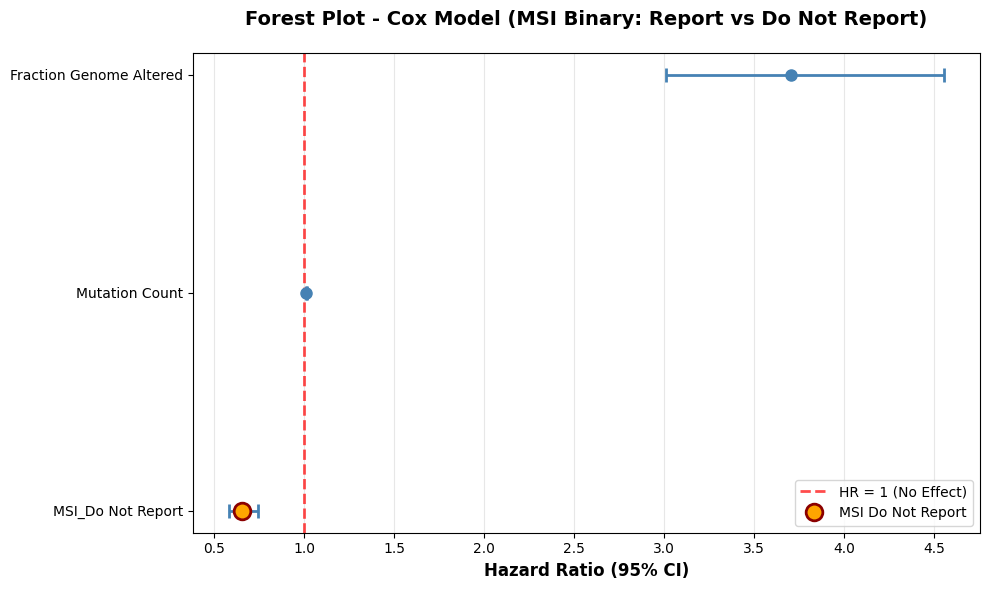


Interpretasi Forest Plot:
- Titik = Hazard Ratio
- Garis horizontal = 95% Confidence Interval
- HR > 1 (kanan garis merah) = Meningkatkan risiko kematian
- HR < 1 (kiri garis merah) = Menurunkan risiko kematian
- Titik oranye (jika ada) = MSI Do Not Report


In [136]:
# Plot hazard ratio dengan confidence interval untuk model binary
fig, ax = plt.subplots(figsize=(10, max(6, len(final_cox_model_binary.params_) * 0.5)))

summary_final_binary = final_cox_model_binary.summary
vars_sorted_binary = summary_final_binary.sort_values('exp(coef)').index

y_pos = np.arange(len(vars_sorted_binary))
hrs_binary = summary_final_binary.loc[vars_sorted_binary, 'exp(coef)']
ci_lower_binary = summary_final_binary.loc[vars_sorted_binary, 'exp(coef) lower 95%']
ci_upper_binary = summary_final_binary.loc[vars_sorted_binary, 'exp(coef) upper 95%']

# Plot points dan error bars
ax.errorbar(hrs_binary, y_pos, xerr=[hrs_binary - ci_lower_binary, ci_upper_binary - hrs_binary], 
            fmt='o', markersize=8, capsize=5, capthick=2, linewidth=2, color='steelblue')

# Garis referensi di HR = 1
ax.axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.7, label='HR = 1 (No Effect)')

# Highlight MSI Do Not Report jika ada
if 'MSI_Do Not Report' in vars_sorted_binary:
    idx_msi = list(vars_sorted_binary).index('MSI_Do Not Report')
    ax.plot(hrs_binary.iloc[idx_msi], idx_msi, 'o', markersize=12, 
            color='orange', markeredgewidth=2, markeredgecolor='darkred', 
            label='MSI Do Not Report', zorder=5)

# Format
ax.set_yticks(y_pos)
ax.set_yticklabels(vars_sorted_binary)
ax.set_xlabel('Hazard Ratio (95% CI)', fontsize=12, fontweight='bold')
ax.set_title('Forest Plot - Cox Model (MSI Binary: Report vs Do Not Report)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("\nInterpretasi Forest Plot:")
print("- Titik = Hazard Ratio")
print("- Garis horizontal = 95% Confidence Interval")
print("- HR > 1 (kanan garis merah) = Meningkatkan risiko kematian")
print("- HR < 1 (kiri garis merah) = Menurunkan risiko kematian")
print("- Titik oranye (jika ada) = MSI Do Not Report")

### Uji Asumsi Proportional Hazards - Model Binary

In [137]:
# Siapkan data untuk model final binary
final_predictors_binary = list(final_cox_model_binary.params_.index)
data_final_binary = data_cox_binary_encoded[['Overall Survival (Months)', 'Overall Survival Status'] + final_predictors_binary].copy()

print("=" * 80)
print("UJI ASUMSI PROPORTIONAL HAZARDS - MODEL BINARY MSI")
print("=" * 80)
print(f"\nJumlah variabel dalam model final: {len(final_predictors_binary)}")
print("\nVariabel yang diuji:")
for i, var in enumerate(final_predictors_binary, 1):
    print(f"  {i}. {var}")

# Proportional Hazard Test
print("\n" + "=" * 80)
print("PROPORTIONAL HAZARD TEST")
print("=" * 80)

result_final_binary = proportional_hazard_test(final_cox_model_binary, data_final_binary, time_transform='rank')

print("\nHasil Test (time_transform='rank'):")
print(result_final_binary)

print("\n" + "=" * 80)
print("INTERPRETASI HASIL")
print("=" * 80)

# Interpretasi per variabel
test_results_binary = result_final_binary.summary
for idx in test_results_binary.index:
    p_val = test_results_binary.loc[idx, 'p']
    test_stat = test_results_binary.loc[idx, 'test_statistic']
    
    print(f"\n{idx}:")
    print(f"  Test Statistic: {test_stat:.4f}")
    print(f"  P-value: {p_val:.4f}")
    
    if p_val < 0.05:
        print(f"  ❌ TIDAK memenuhi asumsi (p-value < 0.05)")
    else:
        print(f"  ✓ Memenuhi asumsi (p-value >= 0.05)")

# Overall test
print("\n" + "=" * 80)
print("KESIMPULAN OVERALL")
print("=" * 80)

violations_binary = test_results_binary[test_results_binary['p'] < 0.05]
if len(violations_binary) == 0:
    print("\n✓ SEMUA variabel memenuhi asumsi proportional hazards!")
    print("  Model Binary MSI dapat digunakan dengan confidence.")
else:
    print(f"\n❌ Terdapat {len(violations_binary)} variabel yang melanggar asumsi:")
    for var in violations_binary.index:
        print(f"  - {var} (p-value = {violations_binary.loc[var, 'p']:.4f})")

UJI ASUMSI PROPORTIONAL HAZARDS - MODEL BINARY MSI

Jumlah variabel dalam model final: 3

Variabel yang diuji:
  1. Mutation Count
  2. Fraction Genome Altered
  3. MSI_Do Not Report

PROPORTIONAL HAZARD TEST

Hasil Test (time_transform='rank'):
<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3656 total observations, 1609 right-censored observations>
         test_name = proportional_hazard_test

---
                         test_statistic    p  -log2(p)
Fraction Genome Altered            0.19 0.66      0.59
MSI_Do Not Report                  0.00 0.99      0.01
Mutation Count                     0.52 0.47      1.09

INTERPRETASI HASIL

Fraction Genome Altered:
  Test Statistic: 0.1881
  P-value: 0.6645
  ✓ Memenuhi asumsi (p-value >= 0.05)

MSI_Do Not Report:
  Test Statistic: 0.0001
  P-value: 0.9903
  ✓ Memenuhi asumsi (p-value >= 0.05)



## Conclusion

Analisis survival breast cancer MSK 2025 telah selesai, termasuk preprocessing data, pemodelan Cox Proportional Hazards, dan perbandingan kurva Kaplan-Meier berdasarkan jenis kelamin. Periksa hasil uji asumsi dan interpretasi model untuk wawasan lebih lanjut.